In [13]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, EvenProcess, GoldenMean, Mess3, RIP, TransitionMatrixProcess
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.comp_mech.reversal import reverse_process, get_recurrent_component_process_from_mstree, get_prob_forward_given_past, joint_prob_from_conditional
from epsilon_transformers.comp_mech.reversal import joint_prob_from_conditional
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
from typing import Dict, Tuple

import numpy as np
import torch
import plotly.express as px
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
p = RIP()
p_rev = reverse_process(p)
print(f"p_rev.steady_state_vector: {p_rev.steady_state_vector}")
print(f"p.steady_state_vector: {p.steady_state_vector}")

[[[0.   0.   0.  ]
  [1.   0.   0.  ]
  [0.   0.25 0.  ]]

 [[0.   0.   1.  ]
  [0.   0.   0.  ]
  [0.5  0.25 0.  ]]]
p_rev.steady_state_vector: [0.4 0.2 0.4]
p.steady_state_vector: [0.4 0.2 0.4]


In [48]:
.5/2.5

0.2

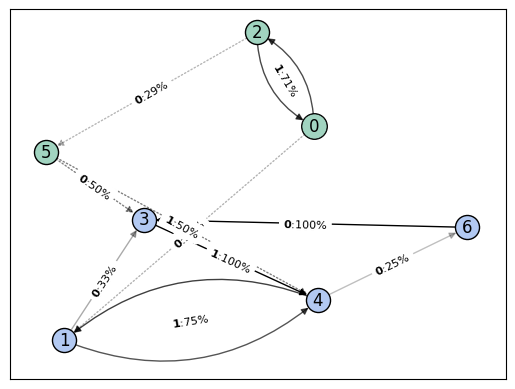

In [49]:
msp_rev = p_rev.derive_mixed_state_tree(depth=4)
msp_rev_T, belief_distributions = msp_rev.build_msp_transition_matrix()
visualize_graph(transition_matrix_to_graph(transition_matrix=msp_rev_T), draw_mixed_state=True)

In [50]:
belief_distributions

{0: array([0.4, 0.2, 0.4]),
 1: array([0.66666667, 0.33333333, 0.        ]),
 2: array([0.28571429, 0.14285714, 0.57142857]),
 3: array([1., 0., 0.]),
 4: array([0., 0., 1.]),
 5: array([0.5, 0.5, 0. ]),
 6: array([0., 1., 0.])}

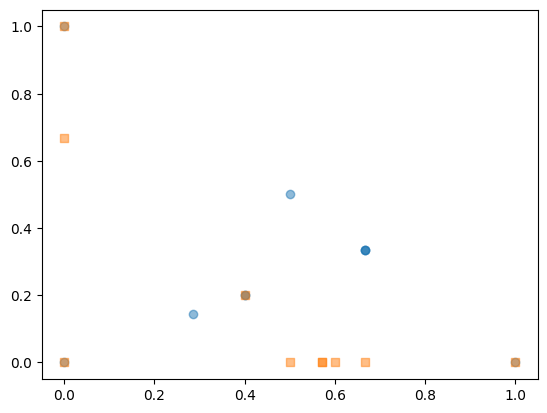

In [51]:
def get_and_plot_paths_beliefs(msp):
    paths = msp.paths
    beliefs = np.array(msp.belief_states)
    # only keep unique beliefs
    beliefs = np.unique(beliefs, axis=0)
    
    # List of different markers to cycle through
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']
    
    # Get the current number of scatter plots
    num_plots = len([c for c in plt.gca().get_children() if isinstance(c, plt.matplotlib.collections.PathCollection)])
    
    # Use a different marker for each call, cycling through the list
    marker = markers[num_plots % len(markers)]
    
    plt.scatter(beliefs[:, 0], beliefs[:, 1], alpha=.5, marker=marker)

msp = p.derive_mixed_state_tree(depth=4)
msp_rev = p_rev.derive_mixed_state_tree(depth=4)
get_and_plot_paths_beliefs(msp_rev)
get_and_plot_paths_beliefs(msp)

In [52]:
epsilon_rev, state_dict = get_recurrent_component_process_from_mstree(msp_rev)

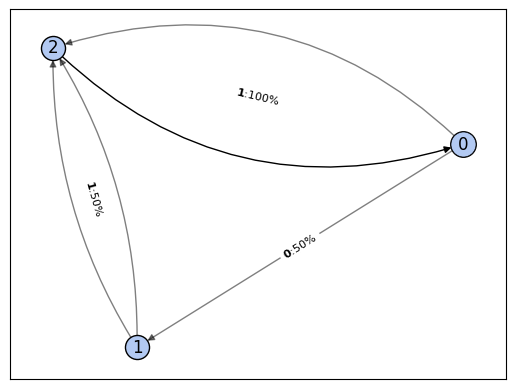

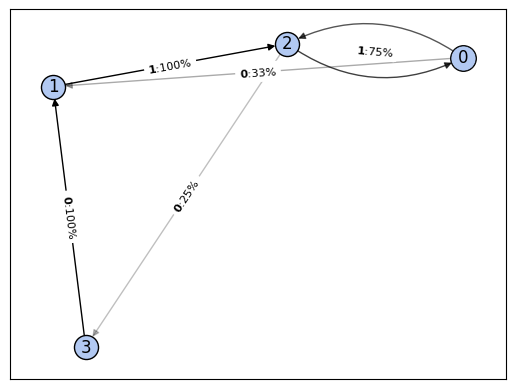

In [53]:

#visualize forward process
visualize_graph(transition_matrix_to_graph(transition_matrix=p.transition_matrix), draw_mixed_state=True)
#visualize reverse process

visualize_graph(transition_matrix_to_graph(transition_matrix=epsilon_rev.transition_matrix), draw_mixed_state=True)

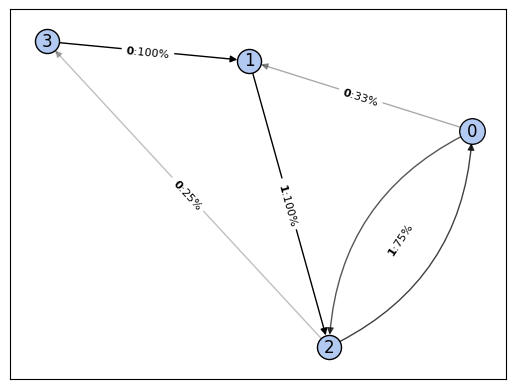

In [54]:

#visualize recurrent process
visualize_graph(transition_matrix_to_graph(transition_matrix=epsilon_rev.transition_matrix), draw_mixed_state=True)

In [55]:
prob_forward_give_reverse = get_prob_forward_given_past(epsilon_rev)
print(f"prob_forward_give_reverse: \n{prob_forward_give_reverse}")

prob_forward_give_reverse: 
[[0.66666667 1.         0.         0.        ]
 [0.33333333 0.         0.         1.        ]
 [0.         0.         1.         0.        ]]


In [68]:
p_F_and_R = joint_prob_from_conditional(prob_forward_give_reverse, epsilon_rev.steady_state_vector)
print(p_F_and_R)

print(f"epsilon_rev.steady_state_vector: {epsilon_rev.steady_state_vector}")
print(f"p_F_and_R.sum(axis=0): {p_F_and_R.sum(axis=0)}")

print(f"p.steady_state_vector: {p.steady_state_vector}")
print(f"p_F_and_R.sum(axis=1): {p_F_and_R.sum(axis=1)}")

[[0.2 0.2 0.  0. ]
 [0.1 0.  0.  0.1]
 [0.  0.  0.4 0. ]]
epsilon_rev.steady_state_vector: [0.3 0.2 0.4 0.1]
p_F_and_R.sum(axis=0): [0.3 0.2 0.4 0.1]
p.steady_state_vector: [0.4 0.2 0.4]
p_F_and_R.sum(axis=1): [0.4 0.2 0.4]


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_36661/2635700894.py:6: RuntimeWarning: divide by zero encountered in log
  uYgX = np.log(pYgX)
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_36661/2635700894.py:21: RuntimeWarning: invalid value encountered in divide
  d[j,i]=np.nansum(pYgX[i,:]*np.log2(pYgX[i,:]/pYgR[j,:]))
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_36661/2635700894.py:21: RuntimeWarning: divide by zero encountered in divide
  d[j,i]=np.nansum(pYgX[i,:]*np.log2(pYgX[i,:]/pYgR[j,:]))
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_36661/2635700894.py:21: RuntimeWarning: divide by zero encountered in log2
  d[j,i]=np.nansum(pYgX[i,:]*np.log2(pYgX[i,:]/pYgR[j,:]))
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_36661/2635700894.py:21: RuntimeWarning: invalid value encountered in multiply
  d[j,i]=np.nansum(pYgX[i,:]*np.log2(pYgX[i,:]/pYgR[j,:]))
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_36661/263

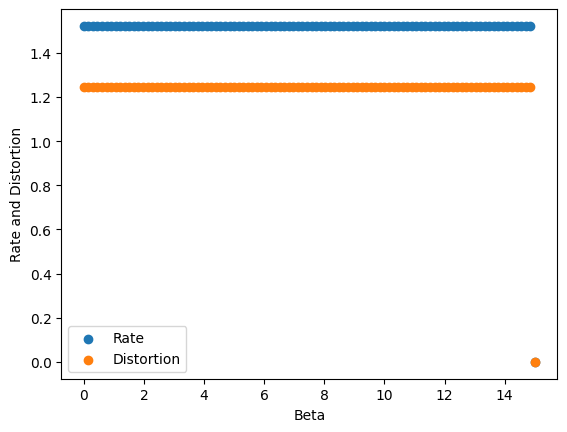

In [69]:
def compute_rate_distortion_curve(p, beta_max=10000, beta_min=0, num_steps=100, max_iterations=50):
    m,n = np.shape(p)
    pX = np.sum(p,1)
    pY = np.sum(p,0)
    pYgX = np.dot(np.diag(1/pX),p)
    uYgX = np.log(pYgX)

	# Lagrange multiplier stepsize
    b=np.linspace(beta_max,beta_min,num_steps)

	# initial conditions
    pRgX = np.eye(m) # conditional of R given X
    pR = np.dot(pRgX,pX) # marginal of R
    pXgR = np.dot(np.dot(np.diag(1/pR),pRgX),np.diag(pX))
    pYgR = np.dot(pXgR,pYgX)

	# get the initial distortion matrix
    d = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            d[j,i]=np.nansum(pYgX[i,:]*np.log2(pYgX[i,:]/pYgR[j,:]))

	# the parametric rate and distortion curves
    R=np.zeros((1,num_steps))
    D=np.zeros((1,num_steps))

	# calculate E
	#E = -np.nansum(pY*np.log2(pY))+np.dot(pX,np.nansum(pYgX*np.log2(pYgX),1))

	# start the procedure!

    foo3, foo4 = np.meshgrid(np.log(pX),np.log(pX))

    for i in range(0,num_steps):
        for t in range(0,5000): # arbitrary, fix this
            # calculate exp(beta*d)
            foo1, foo2 = np.meshgrid(np.log(pR),np.log(pR))
            uRgX = foo2-b[i]*d
            pRgX = np.exp(uRgX) #np.dot(np.diag(pR),np.exp(-b[i]*d))
            # calculate new partition function
            Z = np.sum(pRgX,0)
            # calculate new conditional distribution (with old marginal)
            foo1, foo2 = np.meshgrid(np.log(Z),np.log(Z))
            uRgX = uRgX - foo1
            pRgX = np.exp(uRgX)
            # calculate new marginal
            pR = np.dot(pRgX,pX)
            # calculate new p(y|R) from new conditional
            foo1, foo2 = np.meshgrid(np.log(pR),np.log(pR))
            uXgR = -foo2+uRgX+foo3
            pXgR = np.exp(uXgR)
            pYgR = np.dot(pXgR,pYgX)
            uYgR = np.log(pYgR)
            # calculate new distortion matrix
            for j in range(m):
                for k in range(m):
                    d[k,j]=np.nansum(pYgX[j,:]*(uYgX[j,:]-uYgR[k,:]))
        # calculate new rate, I[R,X]
        R[0,i]=-np.nansum(pR*np.log2(pR))+np.dot(pX,np.nansum(pRgX*np.log2(pRgX),0))
        if R[0,i]<.001:
            break
        # calculate new I[R,Y]
        D[0,i]=-np.nansum(pY*np.log2(pY))+np.dot(pR,np.nansum(pYgR*np.log2(pYgR),1))
		
        
    return R, D

rates, distortions = compute_rate_distortion_curve(p_F_and_R, beta_max=15, beta_min=0, num_steps=100, max_iterations=50)
beta_values = np.linspace(0, 15, 100)

plt.scatter(beta_values, rates, label='Rate')
plt.scatter(beta_values, distortions, label='Distortion')
plt.xlabel('Beta')
plt.ylabel('Rate and Distortion')
plt.legend()
plt.show()

In [58]:
distortions

array([[1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24643934, 1.24643934,
        1.24643934, 1.24643934, 1.24643934, 1.24

In [61]:
def PRD(p,beta):
	# uses accuracy rather than pred power
	# d(x,xhat) = p(x=xhat|sigma)
	# calculate p(x|sigma)
	pX = np.sum(p,0)
	pS = np.sum(p,1)
	pXgS = np.dot(np.diag(1/pS),p) # [m,m]
	# get distortion matrix
	d = pXgS
	#
	pXhatgS0 = np.random.uniform(size=len(pS))
	pXhatgS = np.vstack([pXhatgS0,1-pXhatgS0]).T
	pXhat = np.dot(pXhatgS.T,pS) #np.sum(np.dot(np.diag(pS),pXhatgS),0)
	# loop
	for t in range(5000): # fix this
		log_pXhatgS = np.meshgrid(np.log(pXhat),np.ones(len(pS)))[0]+beta*d
		pXhatgS = np.exp(log_pXhatgS)
		Zs = np.sum(pXhatgS,1)
		pXhatgS = np.dot(np.diag(1/Zs),pXhatgS)
		pXhat = np.dot(pXhatgS.T,pS)
	#
	R = -np.nansum(pXhat*np.log(pXhat))+np.dot(pS,np.nansum(pXhatgS*np.log(pXhatgS),1)) 
	D = np.dot(pS,np.sum(pXhatgS*pXgS,1))
	return R, D

R,D = PRD(p_F_and_R, 0.5)

ValueError: operands could not be broadcast together with shapes (3,2) (3,4) 

In [60]:
p_F_and_R

array([[0.2, 0.2, 0. , 0. ],
       [0.1, 0. , 0. , 0.1],
       [0. , 0. , 0.4, 0. ]])